# Question 1 and 2

In [6]:
%%writefile main.cu
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <math.h>
#include <cuda.h>

// Define matrix size. You can override this at compile time (e.g., nvcc main.cu -DN=1024 -o main)

#ifndef MATRIX_SIZE
#define MATRIX_SIZE 512
#endif

#define TOLERANCE 1e-4

// Function to initialize a matrix with random values
void initMatrix(float *matrix, int size) {
    for (int i = 0; i < size; i++) {
        // Random values between 0 and 99
        matrix[i] = (float)(rand() % 100);
    }
}

// CPU matrix multiplication
void matrixMulCPU(float *A, float *B, float *C, int n) {
    for (int i = 0; i < n; i++) {
        for (int j = 0; j < n; j++) {
            float sum = 0.0f;
            for (int k = 0; k < n; k++) {
                sum += A[i * n + k] * B[k * n + j];
            }
            C[i * n + j] = sum;
        }
    }
}

// GPU matrix multiplication kernel
__global__ void matrixMulGPU(const float *A, const float *B, float *C, int n) {
    // Each thread computes one element of the output matrix.
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    
    if (row < n && col < n) {
        float sum = 0.0f;
        for (int k = 0; k < n; k++) {
            sum += A[row * n + k] * B[k * n + col];
        }
        C[row * n + col] = sum;
    }
}

// Function to compare CPU and GPU results with an absolute difference tolerance.
void verifyResults(float *C_cpu, float *C_gpu, int n) {
    int errors = 0;
    for (int i = 0; i < n * n; i++) {
        float diff = fabs(C_cpu[i] - C_gpu[i]);
        if (diff > TOLERANCE) {
            errors++;
            if(errors < 10) {
                printf("Mismatch at index %d: CPU = %f, GPU = %f, diff = %f\n", i, C_cpu[i], C_gpu[i], diff);
            }
        }
    }
    if (errors > 0) {
        printf("Total mismatches: %d\n", errors);
    } else {
        printf("Results match within tolerance (%e).\n", TOLERANCE);
    }
}

int main() {
    srand(time(NULL));

    int matrixSize = MATRIX_SIZE;
    size_t bytes = matrixSize * matrixSize * sizeof(float);

    // Allocate host memory
    float *h_A      = (float *)malloc(bytes);
    float *h_B      = (float *)malloc(bytes);
    float *h_C_CPU  = (float *)malloc(bytes);
    float *h_C_GPU  = (float *)malloc(bytes);

    // Initialize matrices
    initMatrix(h_A, matrixSize * matrixSize);
    initMatrix(h_B, matrixSize * matrixSize);

    // ---------------------------
    // CPU matrix multiplication
    // ---------------------------
    cudaEvent_t startCPU, endCPU;
    cudaEventCreate(&startCPU);
    cudaEventCreate(&endCPU);

    cudaEventRecord(startCPU, 0);
    matrixMulCPU(h_A, h_B, h_C_CPU, matrixSize);
    cudaEventRecord(endCPU, 0);
    cudaEventSynchronize(endCPU);

    float cpu_time;
    cudaEventElapsedTime(&cpu_time, startCPU, endCPU);
    printf("CPU Execution Time: %f ms\n", cpu_time);

    // ---------------------------
    // GPU matrix multiplication
    // ---------------------------
    // Allocate device memory
    float *d_A, *d_B, *d_C;
    cudaMalloc((void**)&d_A, bytes);
    cudaMalloc((void**)&d_B, bytes);
    cudaMalloc((void**)&d_C, bytes);

    // Copy data to GPU
    cudaMemcpy(d_A, h_A, bytes, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, bytes, cudaMemcpyHostToDevice);

    // Define grid and block dimensions.
    // Here we use 16x16 threads per block.
    int TILE_SIZE = 16;
    dim3 blockDim(TILE_SIZE, TILE_SIZE);
    dim3 gridDim((matrixSize + blockDim.x - 1) / blockDim.x,
                 (matrixSize + blockDim.y - 1) / blockDim.y);

    // Create CUDA events for GPU timing (kernel execution time).
    cudaEvent_t startGPU, endGPU;
    cudaEventCreate(&startGPU);
    cudaEventCreate(&endGPU);

    cudaEventRecord(startGPU, 0);
    matrixMulGPU<<<gridDim, blockDim>>>(d_A, d_B, d_C, matrixSize);
    cudaEventRecord(endGPU, 0);
    cudaEventSynchronize(endGPU);

    float gpu_kernel_time;
    cudaEventElapsedTime(&gpu_kernel_time, startGPU, endGPU);
    printf("GPU Kernel Execution Time: %f ms\n", gpu_kernel_time);

    // Copy results back to host
    cudaMemcpy(h_C_GPU, d_C, bytes, cudaMemcpyDeviceToHost);

    // Verify results between CPU and GPU
    verifyResults(h_C_CPU, h_C_GPU, matrixSize);

    // Compute speedup factor (CPU time / GPU kernel time)
    float speedup = cpu_time / gpu_kernel_time;
    printf("Speedup (CPU time / GPU kernel time): %f\n", speedup);

    // Cleanup host and device memory, and destroy CUDA events
    free(h_A);
    free(h_B);
    free(h_C_CPU);
    free(h_C_GPU);
    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);

    cudaEventDestroy(startCPU);
    cudaEventDestroy(endCPU);
    cudaEventDestroy(startGPU);
    cudaEventDestroy(endGPU);

    return 0;
}


Overwriting main.cu


In [14]:
!nvcc -arch=native -o main main.cu -DMATRIX_SIZE=2048

In [9]:
!./main

CPU Execution Time: 53.650082 ms
GPU Kernel Execution Time: 0.192512 ms
Results match within tolerance (1.000000e-04).
Speedup (CPU time / GPU kernel time): 278.684357


In [11]:
!./main

CPU Execution Time: 729.264404 ms
GPU Kernel Execution Time: 0.608448 ms
Results match within tolerance (1.000000e-04).
Speedup (CPU time / GPU kernel time): 1198.564819


In [13]:
!./main

CPU Execution Time: 7545.719238 ms
GPU Kernel Execution Time: 4.606720 ms
Results match within tolerance (1.000000e-04).
Speedup (CPU time / GPU kernel time): 1637.980835


In [16]:
!./main

CPU Execution Time: 88817.101562 ms
GPU Kernel Execution Time: 47.928032 ms
Results match within tolerance (1.000000e-04).
Speedup (CPU time / GPU kernel time): 1853.134766


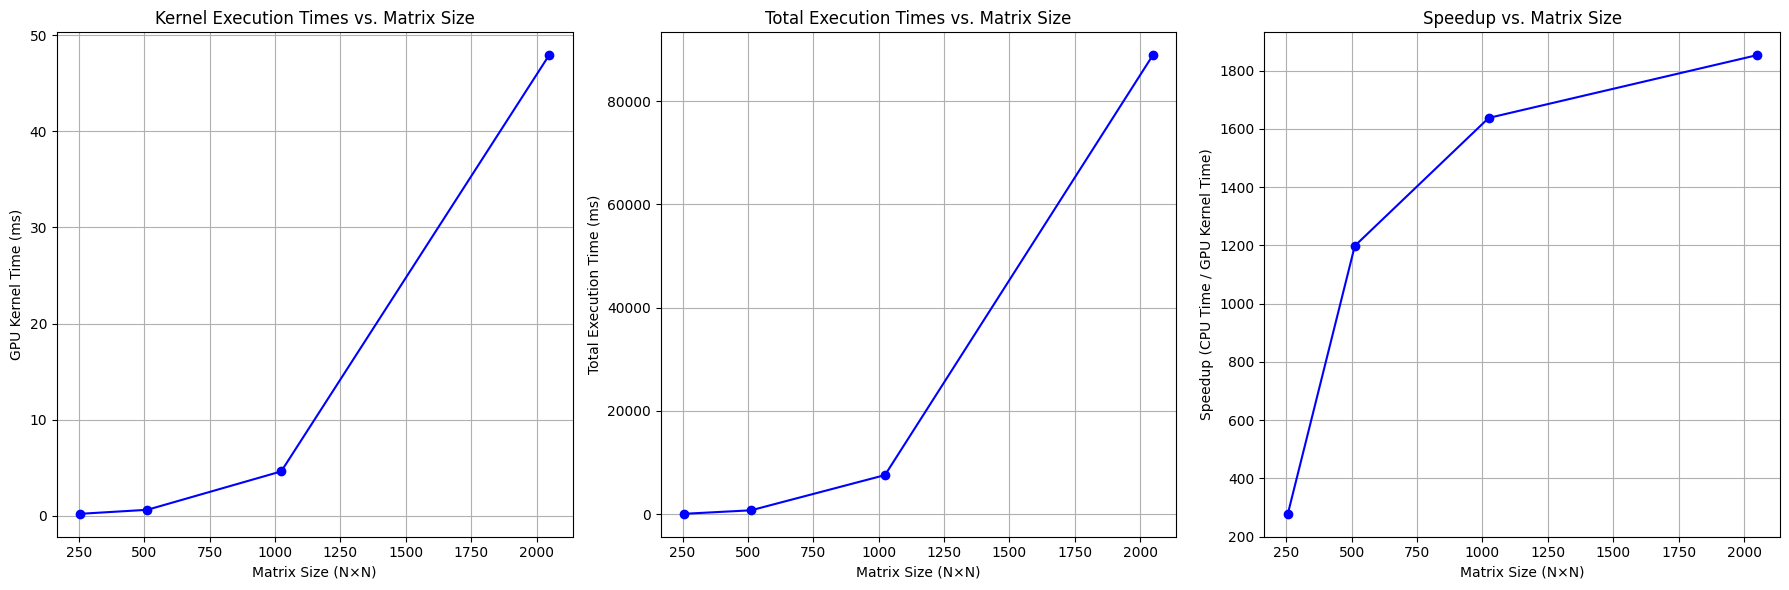

In [1]:
import matplotlib.pyplot as plt

matrix_sizes = [256, 512, 1024, 2048]
cpu_times = [53.650082, 729.264404, 7545.719238, 88817.101562]  # in ms (CPU times)
gpu_times = [0.192512, 0.608448, 4.606720, 47.928032]            # in ms (kernel times)
total_execution_times = [cpu + gpu for cpu, gpu in zip(cpu_times, gpu_times)]
speedup = [cpu / gpu for cpu, gpu in zip(cpu_times, gpu_times)]

# Create a figure with 1 row and 3 columns of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot GPU Kernel Times
axes[0].plot(matrix_sizes, gpu_times, marker='o', linestyle='-', color='b')
axes[0].set_xlabel("Matrix Size (N×N)")
axes[0].set_ylabel("GPU Kernel Time (ms)")
axes[0].set_title("Kernel Execution Times vs. Matrix Size")
axes[0].grid(True)

# Plot Total Execution Times
axes[1].plot(matrix_sizes, total_execution_times, marker='o', linestyle='-', color='b')
axes[1].set_xlabel("Matrix Size (N×N)")
axes[1].set_ylabel("Total Execution Time (ms)")
axes[1].set_title("Total Execution Times vs. Matrix Size")
axes[1].grid(True)

# Plot Speedup
axes[2].plot(matrix_sizes, speedup, marker='o', linestyle='-', color='b')
axes[2].set_xlabel("Matrix Size (N×N)")
axes[2].set_ylabel("Speedup (CPU Time / GPU Kernel Time)")
axes[2].set_title("Speedup vs. Matrix Size")
axes[2].grid(True)

plt.tight_layout()
plt.show()


# Question 3

In [4]:
%%writefile main.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <math.h>
#include <time.h>

#ifndef MATRIX_SIZE
#define MATRIX_SIZE 512  // Matrix size (N x N); override via -DN=...
#endif

// Function to initialize a matrix with random values
void initMatrix(float *matrix, int size) {
    for (int i = 0; i < size; i++) {
        matrix[i] = (float)(rand() % 100);
    }
}

// *****************************
// 1D Grid Kernel (Linearized Indexing)
// *****************************
__global__ void matrixMul1D(const float *A, const float *B, float *C, int n) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int totalElements = n * n;
    if (idx < totalElements) {
        int row = idx / n;
        int col = idx % n;
        float sum = 0.0f;
        for (int k = 0; k < n; k++) {
            sum += A[row * n + k] * B[k * n + col];
        }
        C[idx] = sum;
    }
}

// *****************************
// 2D Grid Kernel (2D Block & Thread Indexing)
// *****************************
__global__ void matrixMul2D(const float *A, const float *B, float *C, int n) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    if (row < n && col < n) {
        float sum = 0.0f;
        for (int k = 0; k < n; k++) {
            sum += A[row * n + k] * B[k * n + col];
        }
        C[row * n + col] = sum;
    }
}

int main() {
    srand(time(NULL));
    
    int matrixSize = MATRIX_SIZE;
    size_t bytes = matrixSize * matrixSize * sizeof(float);
    
    // Allocate host memory
    float *h_A    = (float *)malloc(bytes);
    float *h_B    = (float *)malloc(bytes);
    float *h_C1D  = (float *)malloc(bytes);
    float *h_C2D  = (float *)malloc(bytes);
    
    // Initialize matrices
    initMatrix(h_A, matrixSize * matrixSize);
    initMatrix(h_B, matrixSize * matrixSize);
    
    // Allocate device memory
    float *d_A, *d_B, *d_C;
    cudaMalloc((void**)&d_A, bytes);
    cudaMalloc((void**)&d_B, bytes);
    cudaMalloc((void**)&d_C, bytes);
    
    // Copy matrices A and B to device
    cudaMemcpy(d_A, h_A, bytes, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, bytes, cudaMemcpyHostToDevice);
    
    // **********************************
    // Launch 1D Grid Kernel
    // **********************************
    int totalElements = matrixSize * matrixSize;
    int threadsPerBlock1D = 256;
    int blocks1D = (totalElements + threadsPerBlock1D - 1) / threadsPerBlock1D;
    
    // Create CUDA events for timing the 1D kernel
    cudaEvent_t start1D, stop1D;
    cudaEventCreate(&start1D);
    cudaEventCreate(&stop1D);
    cudaEventRecord(start1D, 0);
    
    // Launch 1D kernel
    matrixMul1D<<<blocks1D, threadsPerBlock1D>>>(d_A, d_B, d_C, matrixSize);
    
    cudaEventRecord(stop1D, 0);
    cudaEventSynchronize(stop1D);
    float time1D;
    cudaEventElapsedTime(&time1D, start1D, stop1D);
    
    // Copy the result from device to host
    cudaMemcpy(h_C1D, d_C, bytes, cudaMemcpyDeviceToHost);
    
    // **********************************
    // Launch 2D Grid Kernel
    // **********************************
    // For 2D grid, choose a 2D block size (e.g., 16x16 threads per block)
    dim3 blockDim2D(16, 16);
    dim3 gridDim2D((matrixSize + blockDim2D.x - 1) / blockDim2D.x,
                   (matrixSize + blockDim2D.y - 1) / blockDim2D.y);
    
    // Clear the device output matrix (optional)
    cudaMemset(d_C, 0, bytes);
    
    // Create CUDA events for timing the 2D kernel
    cudaEvent_t start2D, stop2D;
    cudaEventCreate(&start2D);
    cudaEventCreate(&stop2D);
    cudaEventRecord(start2D, 0);
    
    // Launch 2D kernel
    matrixMul2D<<<gridDim2D, blockDim2D>>>(d_A, d_B, d_C, matrixSize);
    
    cudaEventRecord(stop2D, 0);
    cudaEventSynchronize(stop2D);
    float time2D;
    cudaEventElapsedTime(&time2D, start2D, stop2D);
    
    // Copy the result from device to host
    cudaMemcpy(h_C2D, d_C, bytes, cudaMemcpyDeviceToHost);
    
    // Print the execution times
    printf("Matrix Size: %d x %d\n", matrixSize, matrixSize);
    printf("1D Kernel Execution Time: %f ms\n", time1D);
    printf("2D Kernel Execution Time: %f ms\n", time2D);
    
    // Optionally, verify that both kernels produce the same result
    int errors = 0;
    for (int i = 0; i < totalElements; i++) {
        if (fabs(h_C1D[i] - h_C2D[i]) > 1e-4) {
            errors++;
            if (errors < 10) {
                printf("Mismatch at index %d: 1D = %f, 2D = %f\n", i, h_C1D[i], h_C2D[i]);
            }
        }
    }
    if (errors == 0)
        printf("Results match between 1D and 2D kernels.\n");
    else
        printf("Total mismatches: %d\n", errors);
    
    // Cleanup
    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);
    free(h_A);
    free(h_B);
    free(h_C1D);
    free(h_C2D);
    
    cudaEventDestroy(start1D);
    cudaEventDestroy(stop1D);
    cudaEventDestroy(start2D);
    cudaEventDestroy(stop2D);
    
    return 0;
}


Writing main.cu


In [16]:
!nvcc -arch=native -o main main.cu -DMATRIX_SIZE=256
!nvcc -arch=native -o main1 main.cu -DMATRIX_SIZE=512
!nvcc -arch=native -o main2 main.cu -DMATRIX_SIZE=1024
!nvcc -arch=native -o main3 main.cu -DMATRIX_SIZE=2048

In [17]:
!echo "====== 256 ======"
!./main
!echo "====== 512 ======"
!./main1
!echo "====== 1024 ======"
!./main2
!echo "====== 2048 ======"
!./main3

====== 256 ======
Matrix Size: 256 x 256
1D Kernel Execution Time: 0.174432 ms
2D Kernel Execution Time: 0.091648 ms
Results match between 1D and 2D kernels.
====== 512 ======
Matrix Size: 512 x 512
1D Kernel Execution Time: 0.570656 ms
2D Kernel Execution Time: 0.547136 ms
Results match between 1D and 2D kernels.
====== 1024 ======
Matrix Size: 1024 x 1024
1D Kernel Execution Time: 4.664544 ms
2D Kernel Execution Time: 4.586080 ms
Results match between 1D and 2D kernels.
====== 2048 ======
Matrix Size: 2048 x 2048
1D Kernel Execution Time: 61.623966 ms
2D Kernel Execution Time: 47.857025 ms
Results match between 1D and 2D kernels.


#### Which conguration is more efficient?
#### As the results above show, clearly, the 2D config is more efficient. Mainly because of memory allocation. The inherent 2D nature of the matrix fits better in the 2D kernel execution format leading to more natural thread mapping leading to faster memory access.
#### Also, for the largest martix (2048x2048) the difference is most pronounced because for smaller ones the kernel launch overhead takes a good chunk of the time and the actual execution time difference doesn't get to show itself, however in larger matrices, when it has to execute for longer, the kernel launch time is only a small proportion of the total time meaning the difference in execution times of the 1d and 2d kernels is more stark.